## 01_GriddedDiagnostics_TempAdvection_CFSR: Compute derived quantities using MetPy

## In this notebook, we'll cover the following:
1. Select a date and access various CFSR Datasets
2. Subset the desired Datasets along their dimensions
3. Calculate and visualize diagnostic quantities.
4. Smooth the diagnostic field.

# <span style="color:purple">0) Preliminaries </span>

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# <span style="color:purple">1) Specify a starting and ending date/time, and access several CFSR Datasets</span>

In [3]:
startYear = 2007
startMonth = 2
startDay = 14
startHour = 12
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 2007
endMonth = 2
endDay = 14
endHour = 12
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)


### Create Xarray `Dataset` objects

In [4]:
dsZ = xr.open_dataset ('/cfsr/data/%s/g.%s.0p5.anl.nc' % (startYear, startYear))
dsT = xr.open_dataset ('/cfsr/data/%s/t.%s.0p5.anl.nc' % (startYear, startYear))
dsU = xr.open_dataset ('/cfsr/data/%s/u.%s.0p5.anl.nc' % (startYear, startYear))
dsV = xr.open_dataset ('/cfsr/data/%s/v.%s.0p5.anl.nc' % (startYear, startYear))
dsW = xr.open_dataset ('/cfsr/data/%s/w.%s.0p5.anl.nc' % (startYear, startYear))
dsQ = xr.open_dataset ('/cfsr/data/%s/q.%s.0p5.anl.nc' % (startYear, startYear))
dsSLP = xr.open_dataset ('/cfsr/data/%s/pmsl.%s.0p5.anl.nc' % (startYear, startYear))

# <span style="color:purple">2) Specify a date/time range, and subset the desired `Dataset`s along their dimensions.</span>

Create a list of date and times based on what we specified for the initial and final times, using Pandas' date_range function

In [5]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['2007-02-14 12:00:00'], dtype='datetime64[ns]', freq='6H')

In [6]:
# Areal extent
lonW = -90
lonE = -60
latS = 35
latN = 50
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latS,latN+.5,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+.5,.5) # Need to match longitude values to those of the coordinate variable

Specify the pressure level. 

In [7]:
# Vertical level specificaton
pLevel = 850
levStr = f'{pLevel}'

We will display temperature and wind (and ultimately, temperature advection), so pick the relevant variables.

### Now create objects for our desired DataArrays based on the coordinates we have subsetted.

In [8]:
# Data variable selection
T = dsT['t'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
U = dsU['u'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
V = dsV['v'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)

In [9]:
T

<xarray.DataArray 't' (time: 1, lat: 31, lon: 61)>
array([[[264.6    , 264.80002, ..., 276.2    , 276.2    ],
        [263.9    , 264.30002, ..., 276.     , 276.1    ],
        ...,
        [250.5    , 250.2    , ..., 266.80002, 266.7    ],
        [249.90001, 249.7    , ..., 266.4    , 266.4    ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2007-02-14T12:00:00
    lev      float32 850.0
  * lat      (lat) float32 35.0 35.5 36.0 36.5 37.0 ... 48.0 48.5 49.0 49.5 50.0
  * lon      (lon) float32 -90.0 -89.5 -89.0 -88.5 ... -61.5 -61.0 -60.5 -60.0
Attributes:
    level_type:  Isobaric (hPa)
    units:       K
    long_name:   temperature

### In order to calculate many meteorologically-relevant quantities that depend on distances between gridpoints, we need horizontal distance between gridpoints in meters. MetPy can infer this from datasets such as our CFSR that are lat-lon based, but we need to explicitly assign a coordinate reference system first.

# <span style="color:purple">3) Calculate and visualize diagnostic quantities.</span>

In [10]:
T

<xarray.DataArray 't' (time: 1, lat: 31, lon: 61)>
array([[[264.6    , 264.80002, ..., 276.2    , 276.2    ],
        [263.9    , 264.30002, ..., 276.     , 276.1    ],
        ...,
        [250.5    , 250.2    , ..., 266.80002, 266.7    ],
        [249.90001, 249.7    , ..., 266.4    , 266.4    ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2007-02-14T12:00:00
    lev      float32 850.0
  * lat      (lat) float32 35.0 35.5 36.0 36.5 37.0 ... 48.0 48.5 49.0 49.5 50.0
  * lon      (lon) float32 -90.0 -89.5 -89.0 -88.5 ... -61.5 -61.0 -60.5 -60.0
Attributes:
    level_type:  Isobaric (hPa)
    units:       K
    long_name:   temperature

In [11]:
crsCFSR = {'grid_mapping_name': 'latitude_longitude', 'earth_radius': 6371229.0}
T = T.metpy.assign_crs(crsCFSR)
U = U.metpy.assign_crs(crsCFSR)     #
V = V.metpy.assign_crs(crsCFSR)

In [12]:
T.metpy.assign_crs(crsCFSR)

<xarray.DataArray 't' (time: 1, lat: 31, lon: 61)>
array([[[264.6    , 264.80002, ..., 276.2    , 276.2    ],
        [263.9    , 264.30002, ..., 276.     , 276.1    ],
        ...,
        [250.5    , 250.2    , ..., 266.80002, 266.7    ],
        [249.90001, 249.7    , ..., 266.4    , 266.4    ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2007-02-14T12:00:00
    lev        float32 850.0
  * lat        (lat) float32 35.0 35.5 36.0 36.5 37.0 ... 48.5 49.0 49.5 50.0
  * lon        (lon) float32 -90.0 -89.5 -89.0 -88.5 ... -61.5 -61.0 -60.5 -60.0
    metpy_crs  object Projection: latitude_longitude
Attributes:
    level_type:  Isobaric (hPa)
    units:       K
    long_name:   temperature

Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [13]:
lats = T.lat
lons = T.lon

### First, let's just plot contour lines of temperature and wind barbs.

#### Unit conversions
While we will simply redefine our temperature object so it is in Celsius, let's create two new objects for U and V in knots, since we will want to preserve the original units (m/s) when it comes time to calculate temperature advection.

In [14]:
T = T.metpy.convert_units('degC')
UKts = U.metpy.convert_units('kts')
VKts = V.metpy.convert_units('kts')

Create an array of values for the temperature contours: since we are using contour lines, simply define a range large enough to encompass the expected values, and set a contour interval.

In [15]:
T.min().values, T.max().values

(array(-24.749985, dtype=float32), array(10.25, dtype=float32))

In [16]:
cint = 2
minT, maxT = (-30,22)
TContours = np.arange(minT, maxT, cint)

#### Make the map

In [17]:
constrainLat, constrainLon = (0.5, 4.0)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

Although there is just a single time in our time range, we'll still employ a loop here in case we wanted to include multiple times later on.

Processing 2007-02-14 12:00:00


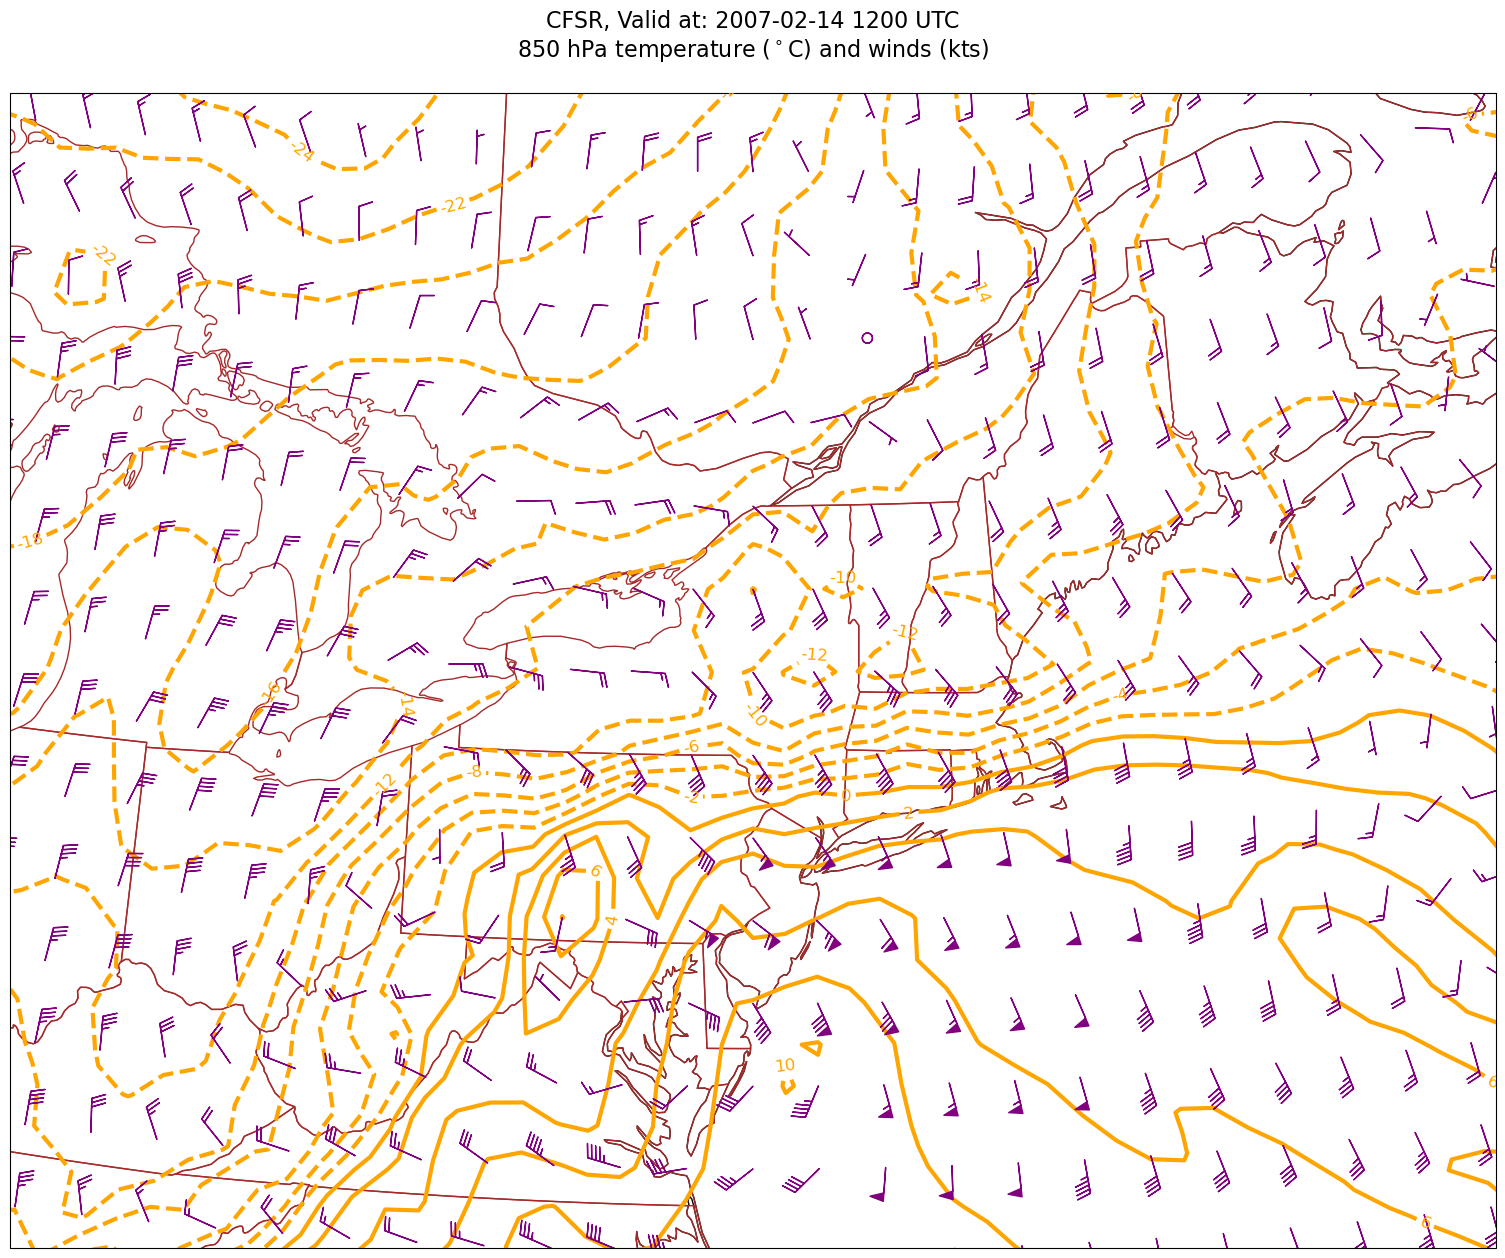

In [18]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa temperature ($^\circ$C) and winds (kts)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1. Contour lines of temperature
    cT = ax.contour(lons, lats, T.sel(time=time), levels=TContours, colors='orange', linewidths=3, transform=proj_data)
    ax.clabel(cT, inline=1, fontsize=12, fmt='%.0f')
    
    # 4. wind barbs
    # Plotting wind barbs uses the ax.barbs method. Here, you can't pass in the DataArray directly; you can only pass in the array's values.
    # Also need to sample (skip) a selected # of points to keep the plot readable.
    # Remember to use Xarray's sel method here as well to specify the current time.
    skip = 2
    ax.barbs(lons[::skip],lats[::skip],UKts.sel(time=time)[::skip,::skip].values, VKts.sel(time=time)[::skip,::skip].values, color='purple',zorder=2,transform=proj_data)

    title = plt.title(title_line,fontsize=16)
    


#### Look at the map and you should easily be able to identify the areas of prominent warm and cold advection. Instead of qualitatively assessing a diagnostic quantity such as temperature advection, how about we quantify it? For that, we will use MetPy's <i>diagnostic library</i>, which we have imported as `mpcalc`.

## [MetPy Diagnostics](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html)

#### Let's explore the `advection` diagnostic: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.advection.html

#### In order to calculate horizontal tempareture advection, we need a <i>scalar</i> quantity (temperature, the "thing" being advected), and a <i>vector</i> field (wind, the "thing" doing the advecting). 

For MetPy's advection function, we pass in the scalar, followed by the vector ... in this case, T followed by U and V.

In [19]:
# Calculate temperature advection by the horizontal wind:
tAdv = mpcalc.advection(T, U, V)

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/metpy/xarray.py:1473: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


Let's look at the output `DataArray`, containing the calculated values (and units) of temperature advection. Note how these values scale ... on the order of 10**-5.

In [20]:
tAdv

Magnitude,[[[-0.0003322399520608143 -0.00011748636092006604 -0.00017971907947280643 ... 0.00013680574296361114 8.861097012837152e-05 3.303582295227412e-05] [-5.80205203094017e-05 3.025560658952654e-05 -9.091413943813749e-05 ... 2.3042825399699456e-05 -1.4971267215472249e-05 -3.197650322546803e-05] [9.249286910152784e-05 7.944999173983773e-05 -8.19642743986367e-06 ... -5.111167912326045e-05 -4.3540692506692764e-05 -2.136078971386966e-05] ... [-7.622809487925563e-05 -0.00016113580996627238 -0.0001577443128766003 ... -3.775022917424554e-05 -2.6516828203045124e-05 -2.5425601180853825e-05] [-6.371896509718659e-05 -0.00011380192791455597 -0.0001534487970819535 ... -5.7347618374897076e-05 -5.077438852311411e-05 -3.0668247414849023e-05] [-0.0001031280981342904 -6.0053018503146365e-05 -0.00012153303334736455 ... -6.240783141330458e-05 -7.935255202819684e-05 -8.389592907881803e-05]]]
Units,kelvin/second


Let's get a quick visualization, using Xarray's built-in interface to Matplotlib.

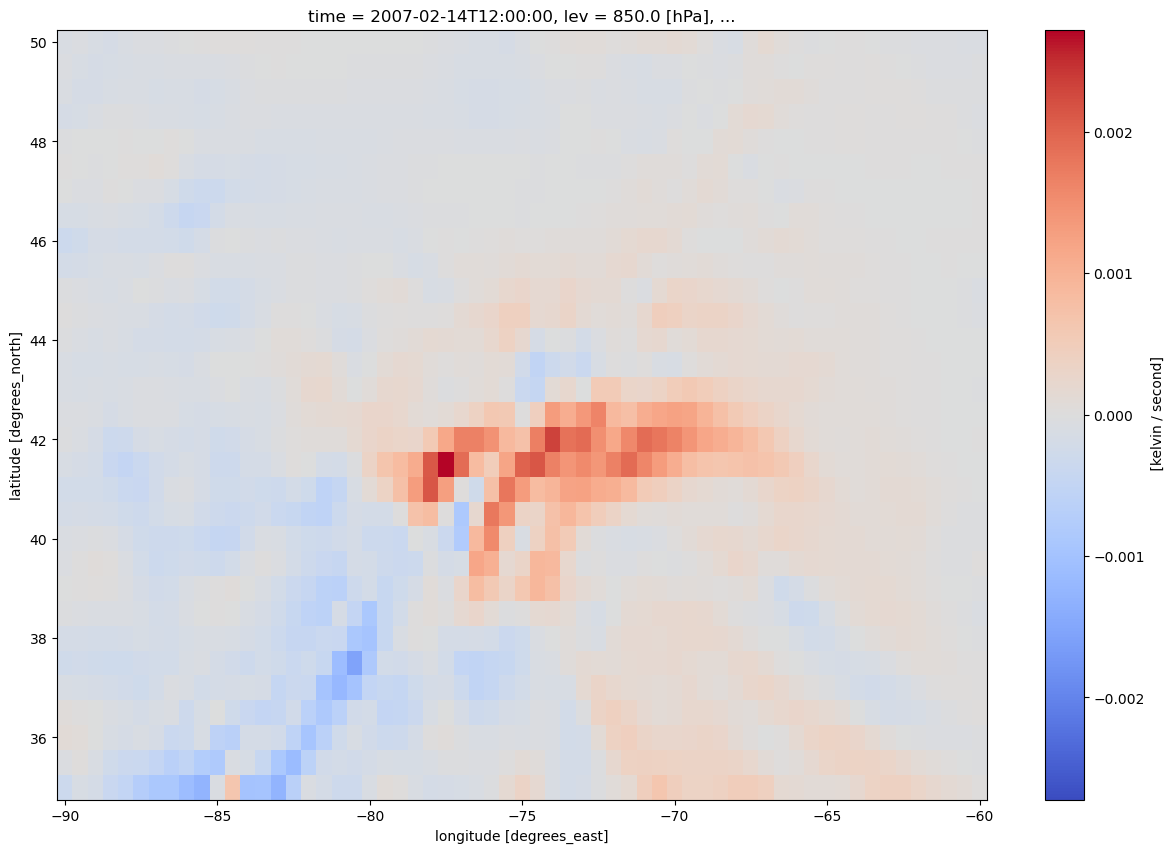

In [25]:
tAdv.plot(figsize=(15,10),cmap='coolwarm')

#### We have three strategies to make the resulting map look nicer:
1. Scale up the values by an appropriate power of ten
2. Focus on the more extreme values of temperature advection: thus, do not contour values that are close to zero.
3. Smooth the values of temperature advection ... especially important in datasets with a high degree of horizontal resolution.

Let's take care of the first two strategies, and then assess the need for smoothing.

### Scale these values up by 1e5 (or 1 * 10**5, or 100,000) and find the min/max values. Use these to inform the setting of the contour fill intervals.

In [26]:
scale = 1e5
minTAdv = (tAdv*scale).min().values
maxTAdv = (tAdv*scale).max().values
print (minTAdv, maxTAdv)

-156.30034272620907 272.3350283440195


### Usually, we wish to avoid plotting the "zero" contour line for diagnostic quantities such as divergence, advection, and frontogenesis. Thus, create two lists of values ... one for negative and one for positive.

In [27]:
advInc = 50
negAdvContours = np.arange (-300, 0, advInc)
posAdvContours = np.arange (50, 350, advInc)

In [28]:
negAdvContours

array([-300, -250, -200, -150, -100,  -50])

### Now, let's plot temperature advection on the map. 

Processing 2007-02-14 12:00:00


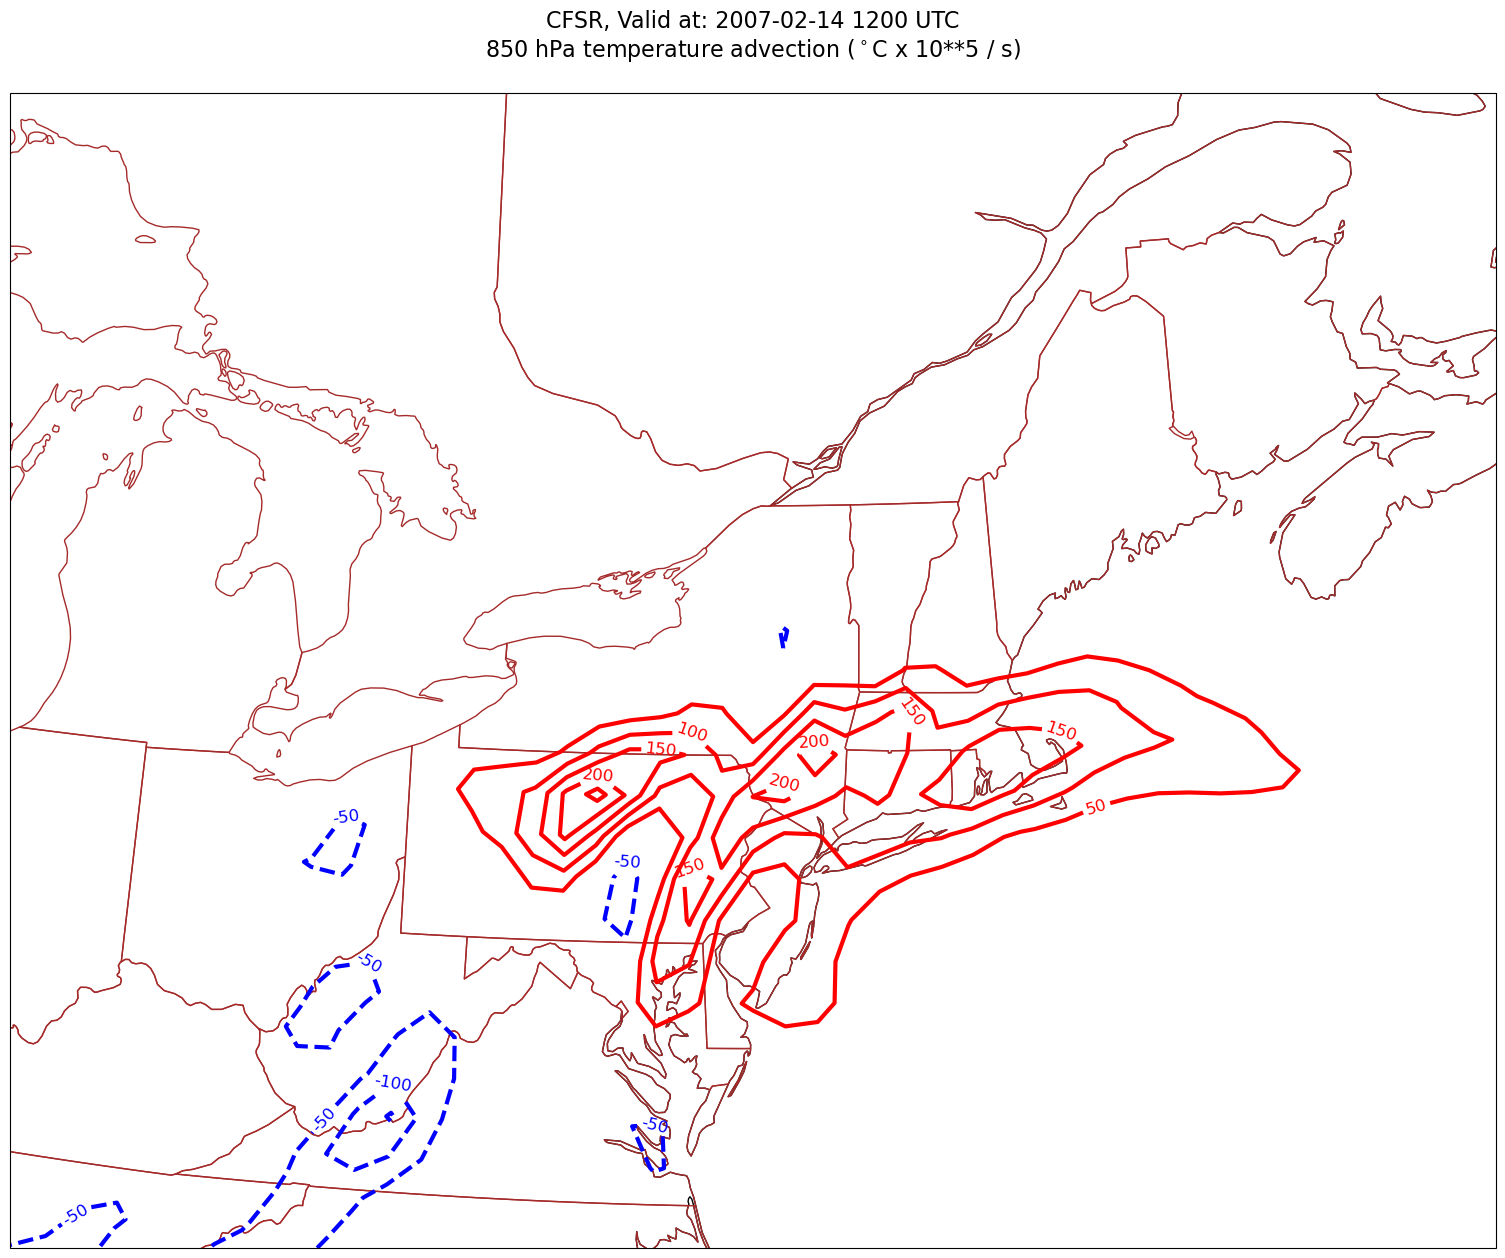

In [30]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa temperature advection ($^\circ$C x 10**5 / s)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, tAdv.sel(time=time)*scale, levels=posAdvContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, tAdv.sel(time=time)*scale, levels=negAdvContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = plt.title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_' + levStr + '_TAdv.png'
    fig.savefig(fileName)


# <span style="color:purple">4. Smooth the diagnostic field.</span>

This is not a terribly "noisy" field. But let's demonstrate the technique of employing a smoothing function. We will use a [Gaussian filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html),  from the [SciPy library](https://scipy.org/scipylib/), which, along with NumPy and Pandas, is one of the core packages in Python's scientific software ecosystem.

MetPy now includes the Gaussian smoother as one of its diagnostics.

In [31]:
sigma = 8.0 # this depends on how noisy your data is, adjust as necessary

tAdvSmooth = mpcalc.smooth_gaussian(tAdv, sigma)

As we did before with the unsmoothed values, let's look at the resulting `DataArray` and its extrema.

In [32]:
tAdvSmooth

Magnitude,[[[-0.00013888692428529385 -0.0001429605088788861 -0.00019186223201693133 ... 8.504917268031794e-05 4.787676303726723e-05 2.710957792870744e-05] [-7.667345116663658e-05 -8.944898838778853e-05 -0.00014072764933242593 ... 4.464185660126668e-05 2.154986181889801e-05 9.248630799458678e-06] [-2.5869996128777404e-05 -4.544710325118405e-05 -9.330431446013004e-05 ... 2.68579056240043e-06 -9.103846586820977e-07 -2.3351211068789813e-06] ... [-0.00010215414329857851 -0.00010531885854271015 -0.00010384923633577242 ... -2.6905113541751028e-05 -3.289964278916449e-05 -3.597434274891741e-05] [-0.00010018942443387926 -0.00010901868208977318 -0.0001170565330115927 ... -4.3294754383638906e-05 -4.742300424872296e-05 -4.8700612473484626e-05] [-9.561150302540875e-05 -0.00010569705132347417 -0.00011844681323664052 ... -5.390391468287193e-05 -5.832247923065558e-05 -5.9916345385414984e-05]]]
Units,kelvin/second


In [33]:
scale = 1e5
minTAdv = (tAdvSmooth * scale).min().values
maxTAdv = (tAdvSmooth * scale).max().values
print (minTAdv, maxTAdv)

-76.07511957712059 136.9952162002647


Not surprisingly, the magnitude of the extrema decreased.

Plot the smoothed advection field.

Processing 2007-02-14 12:00:00


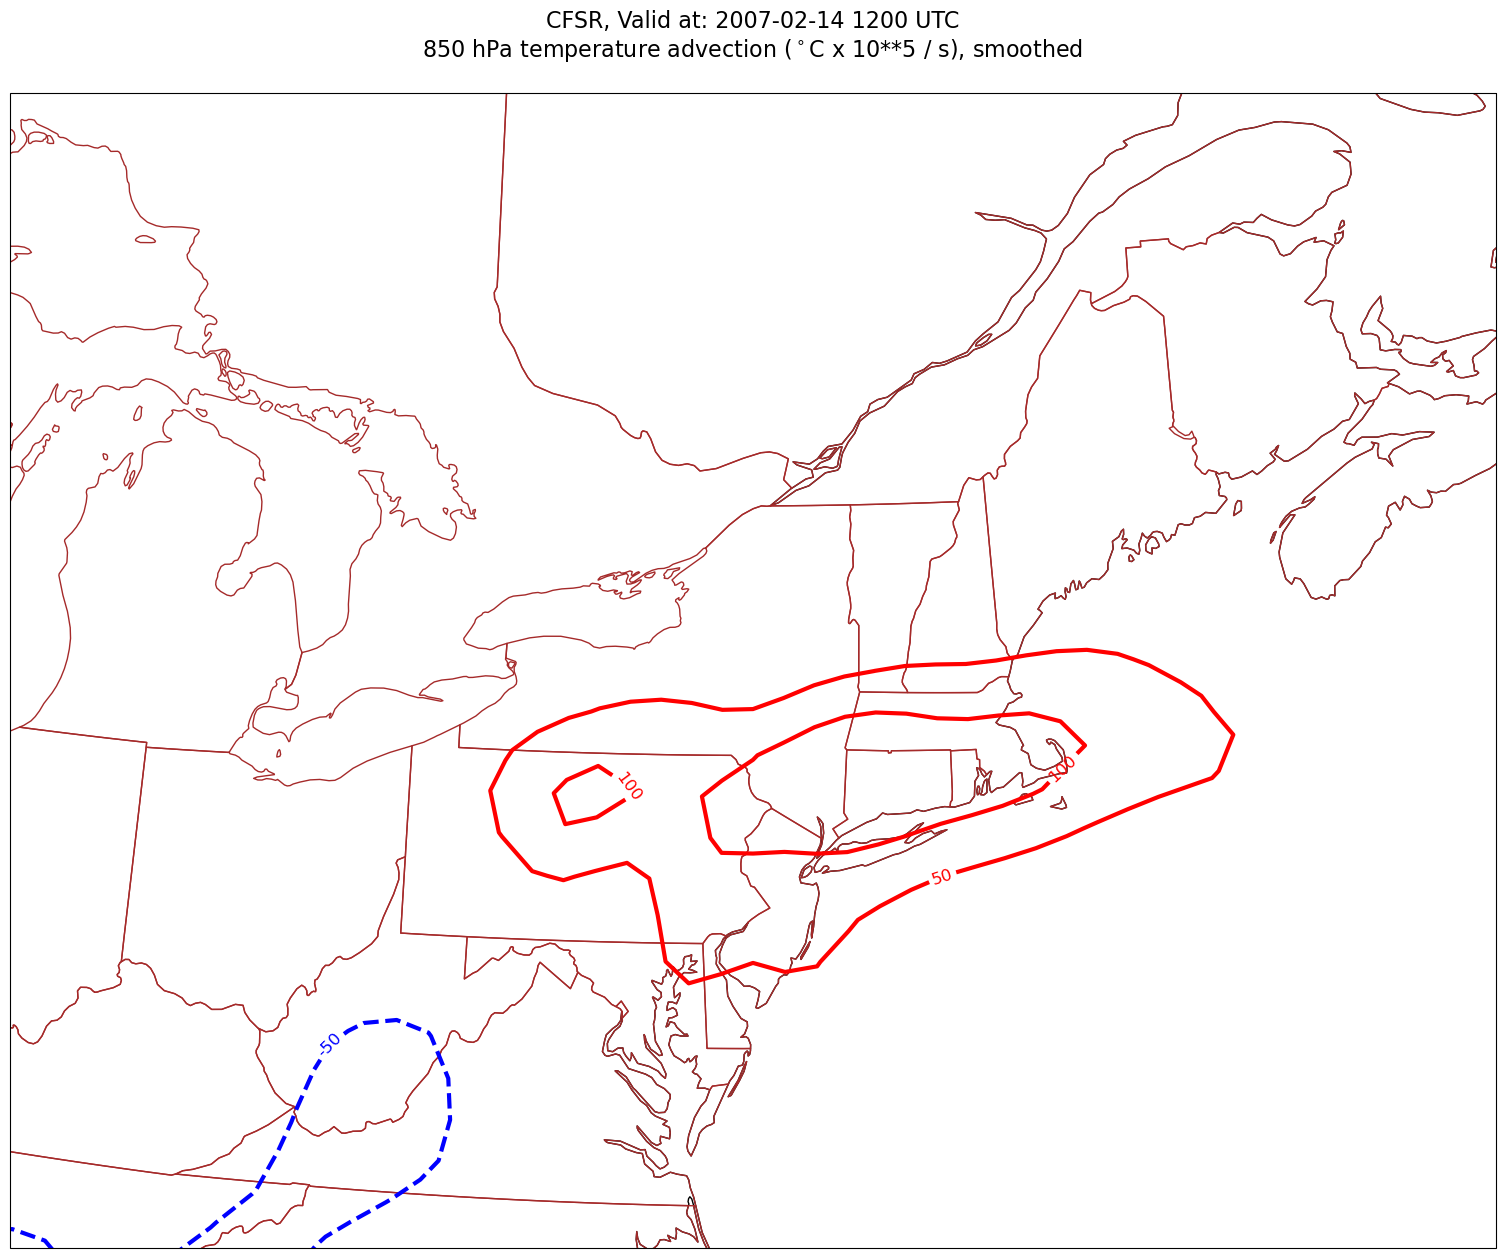

In [34]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa temperature advection ($^\circ$C x 10**5 / s), smoothed"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, tAdvSmooth.sel(time=time)*scale, levels=posAdvContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, tAdvSmooth.sel(time=time)*scale, levels=negAdvContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = plt.title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_' + levStr + '_TAdvSmth.png'
    fig.savefig(fileName)
